In [468]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score as CVS
from sklearn.preprocessing import PolynomialFeatures as PF
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse as RMSE
import scipy.stats as stats
import numbers


## Modelling Function
Takes in the dataframe and optional transform and multicollinearity arguments    
Checks whether to send the data to a transform function   
Selects for x_cols the features from data that are numeric, and not the price   
##### Loop

**1. Remove features with high p-values:**  
- creates the formula using x_cols     
- creates the model using formula   
- creates a dataframe, pv, of the model's p-values  
- creates a new x_cols list from the features in pv with low p-values   

**2. Handle multicollinearity:**     
- Checks whether a function has been passed for handling multicollinearity and calls accordingly    
    
         
            
            
Checks whether the length of x_cols has changed. Loop runs again if it has.     
    
    
When x_cols no longer changes, the final model and x_cols are returned





In [469]:
def modelling(data, selector=simple_selector, transform=None, multicoll=None, alpha=0.05, 
              multicollinearity_threshold = 0.7):
    
    if transform:
        data = transform(data)
        
    outcome = 'price'
    x_cols = [col for col in (data.drop([outcome], axis=1).columns) 
            if isinstance(data[col][0], numbers.Number)]
    i = 0
    while True:
        length0 = len(x_cols)
        print(f'Loop:{i}\nNumber of features: {length0}')
        
        x_cols, pvalues = selector(data, x_cols, alpha)
        length1 = length0-len(x_cols)
        print(f'Removed by Selector: {length1}')
        
        if not i and multicoll:
            x_cols = multicoll(data, x_cols, pvalues, 
                                      multicollinearity_threshold)
            length2 = length0 - length1 - len(x_cols)
            print(f'Removed for multicollinearity: {length2}')
        
        
        i+=1
        if len(x_cols) == length0:
            break
        
    predictors = '+'.join(x_cols)
    f = 'price' + '~' + predictors
    results = ols(formula=f, data=data_train).fit()

    return results, x_cols

In [276]:
def simple_selector(data, x_cols, alpha=0.05):

    predictors = '+'.join(x_cols)
    f = 'price' + '~' + predictors
    results = ols(formula=f, data=data_train).fit()
    pv = pd.DataFrame(results.pvalues).drop('Intercept')
    pv.rename(columns={0:'p_value'}, inplace=True)
    x_cols = list(pv[pv.p_value <= alpha].index)
    
    return x_cols, pv

In [277]:
def stepwise_selector(data, 
                       x_cols=[], 
                       alpha=0.05, 
                       verbose=False):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        x_cols - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    X = data[x_cols]
    y = data['price']
    threshold_in = alpha - 0.02
    threshold_out = alpha + 0.01
    included = list(x_cols)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            results = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = results.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        results = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = results.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
            
    pv = pd.DataFrame(results.pvalues)
    pv.rename(columns={0:'p_value'}, inplace=True)
    return included, pv

## Multicollinearity Function: Remove    
The first multicollinearity function removes a feature from each pair with high multicollinearity    
This function takes in thedata, x_cols and the threshold for removing a feature

- create a dataframe of the correlation of the features in x_cols   
- transform this to get a list of pairs of features with high multicollinearity
- for each pair: check whether they are the same feature or if one of the features has already been listed to be removed; if so, continue to next pair 
- otherwise add the feature with the higher p-value to a list    
- remove the features in this list from x_cols    


return x_cols     




In [85]:
def multicoll_remove(data, x_cols, pvalues, multicollinearity_threshold):
    corr = data[x_cols].corr().abs().stack().reset_index().sort_values(0,
                                                            ascending = False)
    corr['pairs'] = list(zip(corr.level_0, corr.level_1))
    corr = corr.set_index('pairs').drop(['level_0', 'level_1'], axis=1)
    corr.columns = ['cc']
    corr = corr[corr.cc > multicollinearity_threshold]        

    to_drop = []
    for f0, f1 in corr.index:
        if (f0 == f1) | any(feat in [f0, f1] for feat in to_drop):
            continue
        to_drop.append(pvalues.loc[[f0, f1]].sort_values('p_value', 
                                                ascending=False).index[0])
    x_cols = list(set(x_cols) - set(to_drop))
    return x_cols   

In [298]:
def metrics(data, results, x_cols):
#     X = data[x_cols]
#     y = data.price
#     to_pred = pd.concat([y,X], axis=1)
#     yhat = results.predict(to_pred)
#     rmse = RMSE(y, yhat)
    
    linreg = LR()
    linreg.fit(X,y)
    cv  = np.mean(CVS(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
    rmse = (-cv)**0.5
      
    print(f'RMSE: {rmse}')
    
    fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45',
                             fit=True, alpha=0.1)

    fig = plt.figure(figsize=(12,12))
    plt.scatter(data.price, results.resid, alpha=0.5);
    plt.hlines(0, xmax=data.price.max(), xmin=0);    

In [473]:
def transform(data,poly=None):
    """
    poly values: all, list, singles, all_single
    
    """
    data_t = data.copy()
    
    to_poly = []
    to_log = []
    to_norm = []
    to_ohe = []
    poly_order = 2

    if poly in ['all', 'all_single']:
        to_poly = data_t.drop(to_ohe + ['price','date'], axis=1).columns
        if poly == 'all':
            poly = 'list'
        else:
            poly = 'singles'
    if poly == 'list':
        poly=PF(poly_order)
        data_poly = poly.fit_transform(data_t[to_poly])
        data_poly = pd.DataFrame(data_poly)
        data_poly.columns = poly.get_feature_names(data_t[to_poly].columns)
        data_t = pd.concat(data_t.drop(to_poly, axis=1, inplace=True),data_poly)
    elif poly == 'singles':
        for feat in to_poly:
            poly=PF(poly_order)
            data_poly = poly.fit_transform(data_t[feat])
            data_poly = pd.DataFrame(data_poly)
            data_poly.columns = poly.get_feature_names(feat)
            data_t = pd.concat(data_t.drop(feat, axis=1, inplace=True), data_poly)

    for feat in to_log:
        data_t[feat] = data_t[feat].map(lambda x: np.log(x) if x!=0 else 0)
        #Note 'if' included so that 0 values wouldn't error, will still error
        #...between 0 and 1. Also, implies that the original 0 value was a 1
        #...but as these around values of 100s, 1000s, the effect is minimal

    for feat in to_norm:
        f = data_t[feat]
        data_t[feat] = (f-np.mean(f)) / np.sqrt(np.var(f))
        
    for feat in to_ohe:
        
        dummies = pd.get_dummies(data=data_t[feat], prefix=feat, prefix_sep='_',
                                drop_first=True)
        data_t.drop(feat, axis=1, inplace=True)
        data_t = pd.concat([data_t, dummies], axis=1)
    
    return data_t 

#Note data_t = data.copy()   --line added as otherwise the DataFrame, data, 
#...outside of this function lost the first column mentioned in [to_ohe]

In [474]:
transform(data, poly='all')

TypeError: 'NoneType' object is not iterable

In [455]:
data_t = data.copy()
data_t = transform(data, poly=all)
to_norm = ['price', 'sqft_above', 'sqft_basement']
# for feat in to_norm:
#     f = data_t[feat]
# #     print(f, '\nmean',np.mean(f),'\nvar', np.var(f), '\nsqrt',np.sqrt(np.var(f)), '\nnew', (f-np.mean(f)) / np.sqrt(np.var(f)))
#     data_t[feat] = (f-np.mean(f)) / np.sqrt(np.var(f))
data_t

,bathrooms,bedrooms,condition,date,floors,grade,lat,long,price,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode
0,1.00,3,3,2014-10-13,1.0,7,47.5112,-122.257,221900.0,1180,0,1180,1340,5650,5650,0.0,0.0,1955,1955.0,98178
1,2.25,3,3,2014-12-09,2.0,7,47.7210,-122.319,538000.0,2170,400,2570,1690,7242,7639,0.0,0.0,1951,1991.0,98125
2,1.00,2,3,2015-02-25,1.0,6,47.7379,-122.233,180000.0,770,0,770,2720,10000,8062,0.0,0.0,1933,1933.0,98028
3,3.00,4,5,2014-12-09,1.0,7,47.5208,-122.393,604000.0,1050,910,1960,1360,5000,5000,0.0,0.0,1965,1965.0,98136
4,2.00,3,3,2015-02-18,1.0,8,47.6168,-122.045,510000.0,1680,0,1680,1800,8080,7503,0.0,0.0,1987,1987.0,98074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21229,2.50,3,3,2014-05-21,3.0,8,47.6993,-122.346,360000.0,1530,0,1530,1530,1131,1509,0.0,0.0,2009,2009.0,98103
21230,2.50,4,3,2015-02-23,2.0,8,47.5107,-122.362,400000.0,2310,0,2310,1830,5813,7200,0.0,0.0,2014,2014.0,98146
21231,0.75,2,3,2014-06-23,2.0,7,47.5944,-122.299,402101.0,1020,0,1020,1020,1350,2007,0.0,0.0,2009,2009.0,98144
21232,2.50,3,3,2015-01-16,2.0,8,47.5345,-122.069,400000.0,1600,0,1600,1410,2388,1287,0.0,0.0,2004,2004.0,98027


In [406]:
#['bathrooms', 'bedrooms', 'condition', 'date', 'floors', 'grade', 'lat',
#        'long', 'price', 'sqft_above', 'sqft_basement', 'sqft_living',
#        'sqft_living15', 'sqft_lot', 'sqft_lot15', 'view', 'waterfront',
#        'yr_built', 'yr_renovated', 'zipcode']

data_test = transform(data)
data_test

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


,date,floors,grade,lat,long,price,sqft_above,sqft_basement,sqft_living,sqft_living15,...,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,condition_2,condition_3,condition_4,condition_5
0,2014-10-13,1.0,7,47.5112,-122.257,-1.395685,-0.745331,NaN,7.073270,7.200425,...,0,0,0,0,0,0,0,1,0,0
1,2014-12-09,2.0,7,47.7210,-122.319,0.285628,0.689974,NaN,7.851661,7.432484,...,0,0,0,0,0,0,0,1,0,0
2,2015-02-25,1.0,6,47.7379,-122.233,-1.792970,-1.751058,NaN,6.646391,7.908387,...,0,0,0,0,0,0,0,1,0,0
3,2014-12-09,1.0,7,47.5208,-122.393,0.505307,-1.020333,NaN,7.580700,7.215240,...,0,0,0,0,0,0,0,0,0,1
4,2015-02-18,1.0,8,47.6168,-122.045,0.184161,0.086995,NaN,7.426549,7.495542,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21229,2014-05-21,3.0,8,47.6993,-122.346,-0.477076,-0.133352,NaN,7.333023,7.333023,...,0,0,0,0,0,0,0,1,0,0
21230,2015-02-23,2.0,8,47.5107,-122.362,-0.277056,0.837272,NaN,7.745003,7.512071,...,0,0,0,0,0,0,0,1,0,0
21231,2014-06-23,2.0,7,47.5944,-122.299,-0.267111,-1.088628,NaN,6.927558,6.927558,...,0,0,0,0,0,0,0,1,0,0
21232,2015-01-16,2.0,8,47.5345,-122.069,-0.277056,-0.027954,NaN,7.377759,7.251345,...,0,0,0,0,0,0,0,1,0,0


In [453]:
data

,bathrooms,bedrooms,condition,date,floors,grade,lat,long,price,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode
0,1.00,3,3,2014-10-13,1.0,7,47.5112,-122.257,221900.0,1180,0,1180,1340,5650,5650,0.0,0.0,1955,1955.0,98178
1,2.25,3,3,2014-12-09,2.0,7,47.7210,-122.319,538000.0,2170,400,2570,1690,7242,7639,0.0,0.0,1951,1991.0,98125
2,1.00,2,3,2015-02-25,1.0,6,47.7379,-122.233,180000.0,770,0,770,2720,10000,8062,0.0,0.0,1933,1933.0,98028
3,3.00,4,5,2014-12-09,1.0,7,47.5208,-122.393,604000.0,1050,910,1960,1360,5000,5000,0.0,0.0,1965,1965.0,98136
4,2.00,3,3,2015-02-18,1.0,8,47.6168,-122.045,510000.0,1680,0,1680,1800,8080,7503,0.0,0.0,1987,1987.0,98074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21229,2.50,3,3,2014-05-21,3.0,8,47.6993,-122.346,360000.0,1530,0,1530,1530,1131,1509,0.0,0.0,2009,2009.0,98103
21230,2.50,4,3,2015-02-23,2.0,8,47.5107,-122.362,400000.0,2310,0,2310,1830,5813,7200,0.0,0.0,2014,2014.0,98146
21231,0.75,2,3,2014-06-23,2.0,7,47.5944,-122.299,402101.0,1020,0,1020,1020,1350,2007,0.0,0.0,2009,2009.0,98144
21232,2.50,3,3,2015-01-16,2.0,8,47.5345,-122.069,400000.0,1600,0,1600,1410,2388,1287,0.0,0.0,2004,2004.0,98027


In [446]:
x=[1,2,3,4,5,6,]
y=np.power(np.e,-100)
y

3.7200759760208555e-44

In [319]:
p=[]
for x in p:
    print(1)

## Initial Model

Initial model using only cleaned data:

In [398]:
data = pd.read_csv('data/clean.csv')
data.date = pd.to_datetime(data.date)
data.sort_index(axis=1, inplace=True)
data_train, data_test = tts(data, train_size=0.8, random_state=111)

Loop:0
Number of features: 18
Removed by Selector: 2
Loop:1
Number of features: 16
Removed by Selector: 0
RMSE: 217381.61515194134


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2481.
Date:                Wed, 18 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:24:35   Log-Likelihood:            -2.3159e+05
No. Observations:               16987   AIC:                         4.632e+05
Df Residuals:                   16970   BIC:                         4.633e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.309e+07   3.27e+06      3.999      0.000    6.67e+06    1.95e+07
bathrooms      4.427e+04   3597.383     12.307      0.000    3.72e+04    5.13e+04
bedrooms      -4.172e+04   2230.985    -18.699      0.000   -4.61e+04   -3.73e+04
condition      2.687e+04   2657.168     10.113      0.000    2.17e+04    3.21e+04
grade          9.641e+04   2454.954     39.271      0.000    9.16e+04    1.01e+05
lat            6.052e+05   1.21e+04     49.816      0.000    5.81e+05    6.29e+05
long          -1.982e+05   1.52e+04    -13.023      0.000   -2.28e+05   -1.68e+05
sqft_above       93.4993     20.467      4.568      0.000      53.382     133.616
sqft_basement    64.3188     20.413      3.151      0.002      24.308     104.330
sqft_living      96.2041     20.521      4.688      0.000      55.981     136.427
sqft_living15    21.1323      3.945      5.357      0.000      13.400      28.864
sqft_lot15       -1.3133      0.169     -7.769      0.000      -1.645      -0.982
view           5.128e+04   2443.710     20.986      0.000    4.65e+04    5.61e+04
waterfront     6.636e+05   2.01e+04     32.932      0.000    6.24e+05    7.03e+05
yr_built      -3232.0176    141.714    -22.807      0.000   -3509.792   -2954.243
yr_renovated    574.1015    145.970      3.933      0.000     287.986     860.217
zipcode        -627.3845     36.934    -16.987      0.000    -699.779    -554.990
==============================================================================
Omnibus:                    13803.971   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1108358.870
Skew:                           3.379   Prob(JB):                         0.00
Kurtosis:                      41.991   Cond. No.                     2.09e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

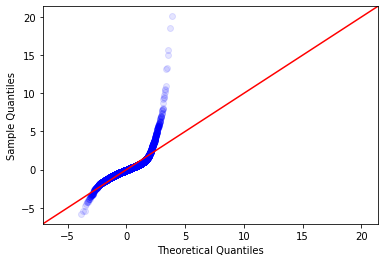

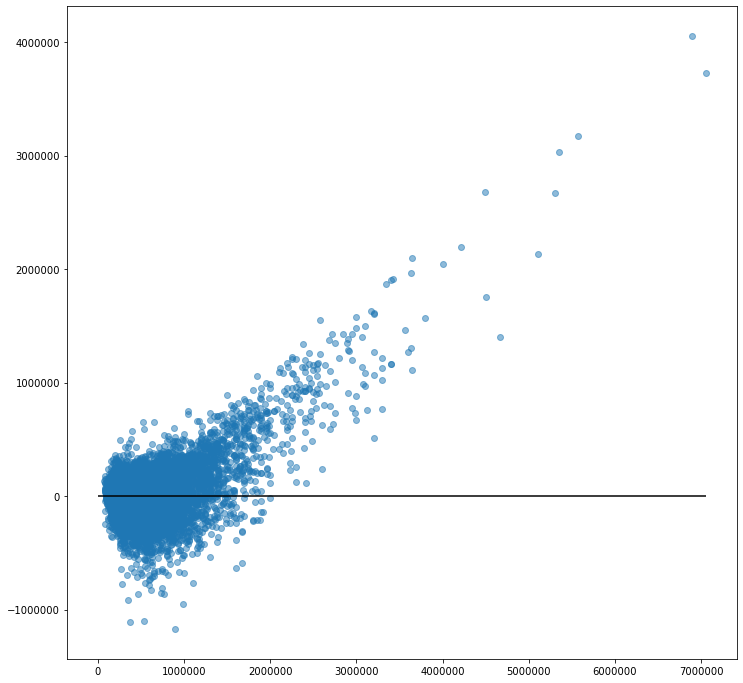

In [297]:
results, x_cols = modelling(data_train)
metrics(data_train, results, x_cols)
results.summary()

Loop:0
Number of features: 18
Removed by Selector: 2
Removed for multicollinearity: 4
Loop:1
Number of features: 12
Removed by Selector: 2
Loop:2
Number of features: 10
Removed by Selector: 0
RMSE: 216938.90494377728


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     3201.
Date:                Wed, 18 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:10:52   Log-Likelihood:            -2.3283e+05
No. Observations:               16987   AIC:                         4.657e+05
Df Residuals:                   16976   BIC:                         4.658e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.374e+07   3.35e+06     10.081      0.000    2.72e+07    4.03e+07
bathrooms      1.133e+05   3251.522     34.832      0.000    1.07e+05     1.2e+05
lat             5.78e+05    1.3e+04     44.515      0.000    5.53e+05    6.03e+05
view           6.146e+04   2583.138     23.794      0.000    5.64e+04    6.65e+04
sqft_basement    51.7196      4.356     11.872      0.000      43.181      60.258
waterfront     6.776e+05   2.16e+04     31.392      0.000    6.35e+05     7.2e+05
condition      1.829e+04   2800.976      6.530      0.000    1.28e+04    2.38e+04
grade          1.709e+05   2028.491     84.234      0.000    1.67e+05    1.75e+05
yr_built      -3359.6118     80.017    -41.986      0.000   -3516.454   -3202.769
zipcode        -646.7394     39.456    -16.391      0.000    -724.077    -569.402
long          -6.319e+04   1.53e+04     -4.125      0.000   -9.32e+04   -3.32e+04
==============================================================================
Omnibus:                    15544.127   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1785880.400
Skew:                           3.993   Prob(JB):                         0.00
Kurtosis:                      52.592   Cond. No.                     1.97e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

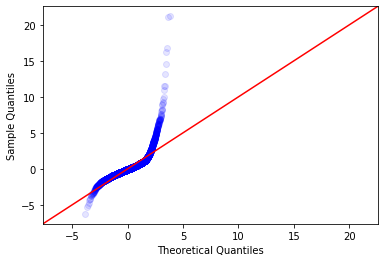

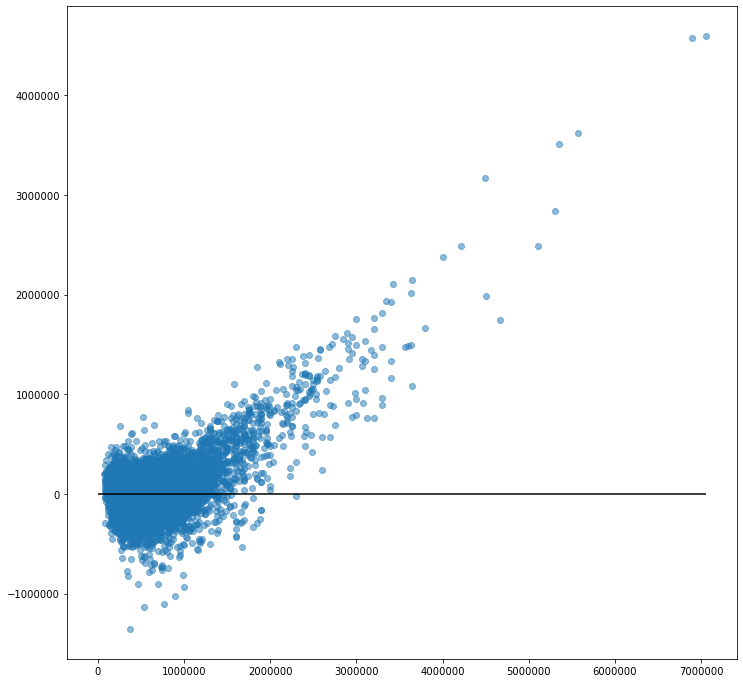

In [285]:
# Model with stepwise selection and removing multicollinear features
results, x_cols = modelling(data_train, selector=stepwise_selector, 
                            multicoll=multicoll_remove)

metrics(data_train, results, x_cols)
results.summary()


In [451]:
results, x_cols = modelling(data_train, transform=transform, selector=stepwise_selector, 
                            multicoll=multicoll_remove)

metrics(data_train, results, x_cols)
results.summary()

Loop:0
Number of features: 30
Removed by Selector: 6
Removed for multicollinearity: 5
Loop:1
Number of features: 19
Removed by Selector: 4
Loop:2
Number of features: 15
Removed by Selector: 0


PatsyError: Error evaluating factor: NameError: name 'bedrooms_3' is not defined
    price~view+grade+sqft_lot15+zipcode+bedrooms_5+bathrooms+lat+sqft_living15+condition_4+condition_5+sqft_basement+waterfront+floors+bedrooms_3+yr_built
                                                                                                                                       ^^^^^^^^^^